In [1]:
from google.colab import drive
import os
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
ratings_dir = Path("/content/drive/MyDrive/deep_learning_training/experiments/letterboxd/crawled/ratings")

df_all = pd.concat(
    (pd.read_csv(f) for f in ratings_dir.glob('*.csv')),
    ignore_index=True
)

print(len(df_all)) # already verified that data has no duplicates

19613961


In [3]:
movie_popularity = df_all["movie_id"].value_counts()
print("Unique movies: ", movie_popularity.count())
print("Most watched movies:")
print(movie_popularity.head())

Unique movies:  399514
Most watched movies:
movie_id
barbie                               9482
parasite-2019                        8914
get-out-2017                         8692
everything-everywhere-all-at-once    8518
la-la-land                           8510
Name: count, dtype: int64


In [4]:
import matplotlib.pyplot as plt
popularity_brackets = movie_popularity.value_counts()
print("Top popularity brackets: ")
print(popularity_brackets.head())

Top popularity brackets: 
count
1    128290
2     58014
3     33243
4     22401
5     16158
Name: count, dtype: int64


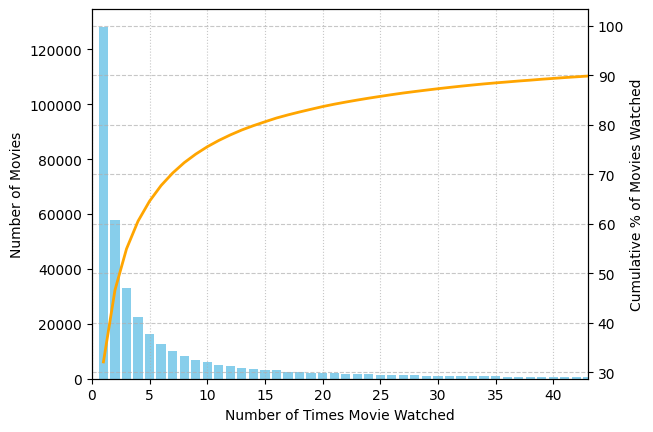

In [5]:
import numpy as np
occurrences = sorted(popularity_brackets.keys())
counts = [popularity_brackets[entry] for entry in occurrences]
cum_percent = np.cumsum(counts) / np.sum(counts) * 100

_, ax1 = plt.subplots()
ax1.bar(occurrences, counts, color='skyblue')
ax1.set_xlabel('Number of Times Movie Watched')
ax1.set_ylabel('Number of Movies')

ax2 = ax1.twinx()
ax2.plot(occurrences, cum_percent, color='orange', linewidth=2)
ax2.set_ylabel('Cumulative % of Movies Watched')

ax1.grid(True, axis='x', linestyle=':', alpha=0.7)
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

limit_width_to_percent = np.searchsorted(cum_percent, 90)
plt.xlim(0,limit_width_to_percent)

plt.show()

np.int64(410)